In [2]:
import torch
from torch import nn
import torchvision.models
import pickle

import torchvision
import torch
from torchvision.transforms import transforms

In [2]:
from torchvision.datasets.utils import download_url
import os
import tarfile
import hashlib

# https://github.com/fastai/imagenette
# dataset_url = 'https://s3.amazonaws.com/fast-ai-imageclas/imagenette2.tgz'
# dataset_filename = dataset_url.split('/')[-1]
# dataset_foldername = dataset_filename.split('.')[0]
# data_path = './data'
# dataset_filepath = os.path.join(data_path,dataset_filename)
# dataset_folderpath = os.path.join(data_path,dataset_foldername)

# os.makedirs(data_path, exist_ok=True)

# download = False
# if not os.path.exists(dataset_filepath):
#     download = True
# # else:
# #     md5_hash = hashlib.md5()


# #     file = open(dataset_filepath, "rb")

# #     content = file.read()

# #     md5_hash.update(content)


# #     digest = md5_hash.hexdigest()
# #     if digest != 'fe2fc210e6bb7c5664d602c3cd71e612':
# #         download = True
# if download:
#     download_url(dataset_url, data_path)

#     with tarfile.open(dataset_filepath, 'r:gz') as tar:
#         tar.extractall(path=data_path)

In [17]:
sampler = torch.utils.data.WeightedRandomSampler(torch.ones(20), 10, replacement=True)
list(sampler)

[2, 12, 19, 13, 19, 1, 10, 12, 16, 11]

In [23]:
list(sampler)

[6, 0, 13, 10, 18, 8, 16, 4, 2, 6]

In [3]:
class TwoCropsTransform:
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform):
        self.base_transform = base_transform

    def __call__(self, x):
        q = self.base_transform(x)
        k = self.base_transform(x)
        return [q, k]

    def __repr__(self):
        format_string = self.__class__.__name__ + '(\n\t'
        format_string += self.base_transform.__repr__().replace('\n', '\n\t')
        format_string += '\n)'
        return format_string

In [4]:
from PIL import ImageFilter
import random

class GaussianBlur(object):
    """Gaussian blur augmentation in SimCLR https://arxiv.org/abs/2002.05709"""

    def __init__(self, sigma=[.1, 2.]):
        self.sigma = sigma

    def __call__(self, x):
        sigma = random.uniform(self.sigma[0], self.sigma[1])
        x = x.filter(ImageFilter.GaussianBlur(radius=sigma))
        return x

In [5]:
# size  = 224
# ks = (int(0.1 * size) // 2) * 2 + 1
# __imagenet_stats = {'mean': [0.485, 0.456, 0.406],
#                     'std': [0.229, 0.224, 0.225]}

#TODO: chose transforms

# train_transform = TwoCropsTransform(transforms.Compose([transforms.RandomResizedCrop(scale=(0.2, 1), size=size),
#                                         transforms.RandomApply([transforms.ColorJitter(0.8, 0.8, 0.8, 0.2)], p=0.8),                  
#                                         transforms.RandomGrayscale(p=0.2),
#                                         transforms.RandomApply([GaussianBlur()], p=0.1),
#                                         transforms.RandomHorizontalFlip(),
#                                         transforms.ToTensor(),
#                                         transforms.Normalize(**__imagenet_stats)]))

# dataset_train = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'train'), train_transform)
#valid_ds = ImageFolder('./data/imagenette-160/val', valid_tfms)

# batch_size = 64
# train_dataloader = torch.utils.data.DataLoader(
#         dataset_train,
#         batch_size=batch_size,
#         num_workers=8,
#         drop_last=True,
#         shuffle=True,
# )

In [6]:
from torch.nn import functional as F
def contrastive_loss(z1, z2, tau=0.2):
    N = z1.shape[0]
    logits = torch.mm(z1, z2.t())  # [N, N] pairs
    labels = torch.arange(N).cuda()  # positives are in diagonal
    loss = F.cross_entropy(logits / tau, labels)
    return 2 * tau * loss

In [7]:
# class MoCoV2(nn.Module):
    
#     def __init__(self, Q_size=6400, C=128):
#         super(MoCoV2, self).__init__()
#         self.C = C
#         self.Q_size = Q_size
#         self.queue_head = 0
#         self.queue = torch.randn(C, Q_size, requires_grad=False).cuda()
#         self.queue = nn.functional.normalize(self.queue, dim=0)
#         self.f_k = torchvision.models.resnet50(num_classes=C)
#         self.f_q = torchvision.models.resnet50(num_classes=C)
#         dim_mlp = self.f_q.fc.weight.shape[1]
#         self.f_q.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.f_q.fc)
#         self.f_k.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.f_k.fc)
        
#         for param_q, param_k in zip(self.f_q.parameters(), self.f_k.parameters()):
#             param_k.data.copy_(param_q.data)
#             param_k.requires_grad = False     

#     def forward(self, x1, x2):
#         N = x1.shape[0]
#         query = self.f_q(x1)
#         query = nn.functional.normalize(query, dim=1)
#         with torch.no_grad():
#             k = self.f_k(x2)
#             k = nn.functional.normalize(k, dim=1)
        
#         l_pos = torch.bmm(query.view(N, 1, self.C), k.view(N, self.C, 1)).view(N,1)
#         l_neg = torch.mm(query.view(N, self.C), self.queue.view(self.C, self.Q_size).clone().detach())
        
#         logits = torch.cat([l_pos, l_neg], dim=1)
        
#         #enqueu dequeue
#         self.queue[:, self.queue_head: self.queue_head+ N] = k.clone().t()
#         self.queue_head = (self.queue_head + N) % self.Q_size
#         return logits        
        
        



In [8]:
# model = MoCoV2()


# model.to('cuda')
# print()

In [9]:
# '''Load state dictionary from stopping point'''
# import os
# try:
#     files = [f for f in os.listdir('.') if os.path.isfile(f)]
#     epochs_lst = [int(f.split('_')[1]) for f in files if "snapshot" in f]
#     last_epoch = max(epochs_lst)
#     model.load_state_dict(torch.load(f"snapshot_{last_epoch}"))
# except:
#     last_epoch = 0
    
# print(last_epoch)

In [10]:
# from tqdm.notebook  import tqdm
# import pickle
# epochs = 1000
# print_step = 10
# tau = 0.2
# m = 0.999
# from matplotlib import pyplot as plt
# errors = []

# return # we have already trained the Feature extractor!

# #lr = 5e-2 * 0.9 ** last_epoch

# optimizer = torch.optim.SGD(model.parameters(), lr=5e-2, momentum=0.9)

# lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, epochs, eta_min=0)
# for i in range(last_epoch):
#     lr_sched.step()
# optimizer.zero_grad()


# if not os.path.exists(dataset_filepath):
#     loss_log = []
#     epoch_loss = []
# else:
#     loss_log, epoch_loss = pickle.load(open("loss_logs.pkl", "rb"))

# def train():
#     for epoch in range(last_epoch + 1, epochs + 1):
#         total_loss = 0
#         for batch_idx, ((x1,x2),_) in enumerate(tqdm(train_dataloader)):
#             x1, x2 = x1.cuda(), x2.cuda()
#             logits = model(x1, x2)
#             labels = torch.zeros(x1.shape[0], dtype=torch.long).cuda()
#             loss = nn.functional.cross_entropy(logits / tau, labels)
#             if loss.isnan().item():
#                 print("nan loss")
#                 global errors
#                 errors = [x1, x2]
#                 print(logits)
#                 return
#             optimizer.zero_grad()
#             loss.backward()
#             optimizer.step()
#             with torch.no_grad():
#                 for param_q, param_k in zip(model.f_q.parameters(), model.f_k.parameters()):
#                     param_k.data = m * param_k.data + (1-m) * param_q.data
#             total_loss += loss.item()
#             loss_log.append(loss.item())
#             if batch_idx % print_step == 0:
#                 tqdm.write('Loss {:.4f}'.format(loss.item()))
#         lr_sched.step()
#         print(f"update lr to: {optimizer.param_groups[0]['lr']}")
#         ep_loss = total_loss/len(train_dataloader)
#         print('Epoch {}: mean loss={:.4f}'.format(epoch, ep_loss))
#         epoch_loss.append(ep_loss)
#         if epoch % 10 == 0:
#             torch.save(model.state_dict(), f"snapshot_{epoch}")
#             with open("loss_logs.pkl", "wb") as f:
#                 pickle.dump([loss_log, epoch_loss], f)
        
             
# # train()


In [11]:
# '''Loading the Contrastive Loss logs'''
# with open("loss_logs.pkl",'rb') as f:
#     loss = pickle.load(f)
#     f.close()
    
# from matplotlib import pyplot as plt
# plt.plot(loss[1])
# # plt.xscale('log')
# plt.xlabel('Epoch')
# plt.ylabel('Contrastive Loss')
# plt.figure()

# snaps_hist = []
# for i in range(100):
#     snaps_hist.append(loss[1][i*10])
# print(f"best performing snapshot :{torch.argmin(torch.tensor(snaps_hist))*10} with loss {min(snaps_hist)}")


In [12]:
# print('number of parameters: ', sum(param.numel() for param in model.parameters()))
# print('Num of trainable parameters : ', sum(p.numel() for p in model.parameters() if p.requires_grad))


In [13]:
import dataloader_cifar as dataloader

# Dataset loader

def imagenette_dataset():
    size  = 224
    ks = (int(0.1 * size) // 2) * 2 + 1
    __imagenet_stats = {'mean': [0.485, 0.456, 0.406],
                        'std': [0.229, 0.224, 0.225]}

    #TODO: chose transforms

    train_transform = transforms.Compose([
                                            transforms.RandomResizedCrop(224),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])


    val_transform = transforms.Compose([
                                            transforms.Resize(256),
                                            transforms.CenterCrop(224),
                                            transforms.ToTensor(),
                                            transforms.Normalize(**__imagenet_stats)])

    dataset_train = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'train'), train_transform)
    valid_ds = torchvision.datasets.ImageFolder(os.path.join(dataset_folderpath,'val'), val_transform)

    batch_size = 64
    train_dataloader = torch.utils.data.DataLoader(
            dataset_train,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=True,
    )

    val_dataloader = torch.utils.data.DataLoader(
            valid_ds,
            batch_size=batch_size,
            num_workers=2,
            drop_last=True,
            shuffle=False,
    )
    return train_dataloader, val_dataloader

loader = None

def cifar10_dataset(noise_ratio=0.9):
    stats_file = open('stats_file.txt', 'w')
    noise_mode='sym'
    batch_size=32
    data_path='cifar-10-batches-py/cifar-10-batches-py/'
    global loader
    loader = dataloader.cifar_dataloader('cifar10',r=noise_ratio,noise_mode=noise_mode,batch_size=batch_size,num_workers=5,\
        root_dir=data_path,log=stats_file,noise_file='%s/%.1f_%s.json'%(data_path,noise_ratio,noise_mode))

    # batch shape: images, noise_label, index
    train_dataloader = loader.run('warmup')

    # first_batch = next(iter(train_dataloader))
    # for i in first_batch:
    #     print(i.shape)
    # print(first_batch)

    val_dataloader = loader.run('test')
    return train_dataloader, val_dataloader


train_dataloader, val_dataloader = cifar10_dataset()

loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json


In [14]:
def validate(model, val_dataloader, criterion):

    model.eval()
    with torch.no_grad():

        top1_sum = 0
        top5_sum = 0
        c = 0
        for x,y in tqdm(val_dataloader):
            x = x.cuda()
            # x = torch.randn([64, 128]).cuda()
            y = y.cuda()

            y_hat = model(x)

            acc1, acc5 = accuracy(y_hat, y, (1,5))
            top1_sum += y.shape[0] * acc1
            top5_sum += y.shape[0] * acc5
            c += y.shape[0]
        
        print(f"top-1: {top1_sum / c}, top-5: {top5_sum / c}")
        return top1_sum.item() / c, top5_sum / c



In [15]:
def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].flatten().float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [16]:
class LC(nn.Module):

    def __init__(self, base_encoder, num_classes=10, learn_encoder=False):
        super(LC, self).__init__()
        self.encoder = base_encoder
        if base_encoder is None:
            raise Exception('base encoder is None')
        for p in self.encoder.parameters():
            p.requires_grad = learn_encoder

        self.mlp = nn.Linear(128,num_classes)
        self.sm = nn.Softmax(dim=-1)

    def forward(self, x):
        return self.sm(self.mlp(self.encoder(x)))


In [17]:
from collections import OrderedDict
snapshot_name = "simclr_chkpnt/ckpt_cifar10_resnet50.pth"


def fix_state_dict(state_dict):
    # create new OrderedDict that does not contain `module.`
    new_state_dict = OrderedDict()
    for k, v in state_dict.items():
        name = k[len('encoder.module.'):] # remove `module.`
    return new_state_dict

In [18]:
from resnet import SupCEResNet
net = "resnet50"
chekpoint = torch.load(snapshot_name)
sd = {}
for ke in chekpoint['model']:
    nk = ke.replace('module.', '')
    sd[nk] = chekpoint['model'][ke]
model = SupCEResNet(net, num_classes=10)
for p in model.encoder.parameters():
    p.requires_grad = False
model.load_state_dict(sd, strict=False)
model = model.to("cuda")

In [19]:
from tqdm.notebook  import tqdm
import copy
from resnet import resnet50
# Stage-2
dw_epochs = 20
criterion = nn.CrossEntropyLoss().cuda()
print_step = 100
out_dir="cifar10/clf_learning"
mlp_clf = model
# validate(mlp_clf, val_dataloader, criterion)
print(f"learnable paramters: {sum(torch.numel(p) for p in mlp_clf.parameters() if p.requires_grad)}")

# optimizer
lc_opt = torch.optim.SGD(mlp_clf.parameters(), lr=3e-4 , momentum=0.9)
lr_sched = torch.optim.lr_scheduler.CosineAnnealingLR(lc_opt, dw_epochs, 0)
lc_opt.zero_grad()


lin_loss_log = []
lin_epoch_loss = []
acc1_hist = []
acc5_hist = []

def mlp_train():
    model.eval()
    best_model_wts = copy.deepcopy(mlp_clf.state_dict())
    best_val = 0
    for epoch in range(1, dw_epochs + 1):
        total_loss = 0
        # images, noise_label, index
        for batch_idx, (x, y, index) in enumerate(tqdm(train_dataloader)):
            x = x.cuda()
            y = y.cuda()
            y_hat = mlp_clf(x)
            loss = criterion(y_hat, y)
            
            lc_opt.zero_grad()
            loss.backward()
            lc_opt.step()
            
            total_loss += loss.item()
            lin_loss_log.append(loss.item())
            if batch_idx % print_step == 0:
                tqdm.write('Loss {:.4f}'.format(loss.item()))

        current_epoch_loss = total_loss/len(train_dataloader)
        lin_epoch_loss.append(current_epoch_loss)
        print('Epoch {}: mean loss={:.4f}'.format(epoch, current_epoch_loss))
        lr_sched.step()
        print(f"update lr to: {lc_opt.param_groups[0]['lr']}")
        val,val5 = validate(mlp_clf, val_dataloader, criterion)
        acc1_hist.append(val)
        acc5_hist.append(val5)
        print(f'Accuracy on validation set: {val}' )
        if val > best_val:
            best_val = val
            best_model_wts = copy.deepcopy(mlp_clf.state_dict())

        mlp_clf.train()
        print(f"learnable paramters: {sum(torch.numel(p) for p in mlp_clf.parameters() if p.requires_grad)}")
        if epoch % 10 == 0:
            with open(f"{out_dir}/classifier_loss_logs.pkl", "wb") as f:
                pickle.dump([lin_loss_log, lin_epoch_loss], f)
    return best_model_wts, best_val

# wts, best_val = mlp_train()
# torch.save(wts, f"{out_dir}/final_model_wts.bin")
model.load_state_dict(torch.load(f"{out_dir}/final_model_wts.bin"))
# validate(mlp_clf, val_dataloader, criterion)

learnable paramters: 20490



top-1: tensor([83.5200], device='cuda:0'), top-5: tensor([98.4300], device='cuda:0')


(83.52, tensor([98.4300], device='cuda:0'))

<Figure size 432x288 with 0 Axes>

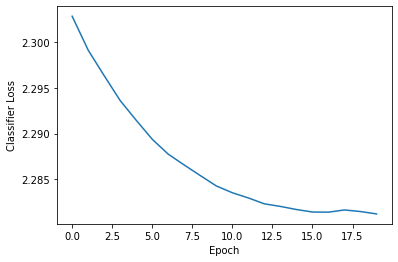

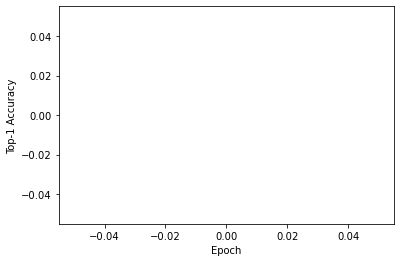

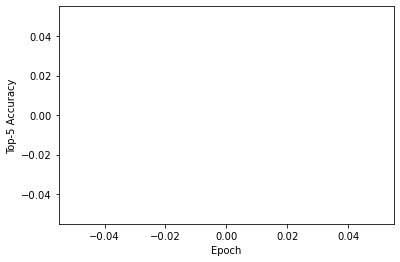

<Figure size 432x288 with 0 Axes>

In [20]:
'''Loading the Classifier Loss logs'''
with open(f"{out_dir}/classifier_loss_logs.pkl",'rb') as f:
    loss = pickle.load(f)
    f.close()
    
from matplotlib import pyplot as plt
plt.plot(loss[1])
# plt.xscale('log')
plt.xlabel('Epoch')
plt.ylabel('Classifier Loss')
plt.figure()


''' plotting the Top-1 & Top-5 accuracy'''
plt.plot(acc1_hist)
plt.xlabel('Epoch')
plt.ylabel('Top-1 Accuracy')
plt.figure()
hist5 = [a.item() for a in acc5_hist]
plt.plot(hist5)
plt.xlabel('Epoch')
plt.ylabel('Top-5 Accuracy')
plt.figure()



In [32]:
from sklearn.mixture import GaussianMixture
import dataloader_cifar as dataloader

def get_train(model, dataloader, estimate_p_right=True, p_right_threshold=0.5, p_clean_threshold=0.5, CBS=True):
    model.eval()
    losses = torch.zeros(len(dataloader.dataset))
    confidence = torch.zeros(len(dataloader.dataset))
    with torch.no_grad():
        for batch_idx, (inputs, targets, index) in enumerate(dataloader):
            inputs, targets = inputs.cuda(), targets.cuda() 
            outputs = model(inputs)
            loss = nn.CrossEntropyLoss(reduction='none')(outputs, targets)
            probs = torch.max(torch.softmax(outputs, dim=-1), dim=-1).values
            for b in range(inputs.size(0)):
                losses[index[b]]=loss[b]
                confidence[index[b]] = probs[b]
    losses = (losses-losses.min())/(losses.max()-losses.min())

    input_loss = losses.reshape(-1, 1)
    confidence = confidence.reshape(-1, 1)
    # fit a two-component GMM to the loss
    gmm1 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
    gmm1.fit(input_loss)
    prob = gmm1.predict_proba(input_loss)
    p_clean = prob[:,gmm1.means_.argmin()]
    clean = (p_clean > p_clean_threshold)
    if estimate_p_right:
        gmm2 = GaussianMixture(n_components=2,max_iter=10,tol=1e-2,reg_covar=5e-4)
        gmm2.fit(confidence)
        prob = gmm2.predict_proba(confidence)
        p_right = prob[:, gmm2.means_.argmax()]
        right = (p_right > p_right_threshold)
        clean = clean | right
    return loader.run('train', clean, p_clean, CBS)

labeled_trainloader, unlabeled_trainloader = get_train(model, loader.run('eval_train'))

loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
labeled data has a size of 7888
using CBS
loading noise file cifar-10-batches-py/cifar-10-batches-py//0.9_sym.json
unlabeled data has a size of 42112


In [39]:
# counter = torch.zeros(10)
# print(counter)
# for i in labeled_trainloader.dataset:
#     counter[i[2]] += 1
# print(counter)
# counter / sum(counter)
i = 0
hist = torch.zeros(10)
for b in labeled_trainloader:
    for j in b[2]:
        hist[j] += 1
    i+= 1

        

NameError: name 'torch' is not defined

In [40]:
hist

tensor([771., 730., 807., 840., 765., 835., 808., 791., 769., 772.])

In [24]:
sorteddel_out = model(torch.rand(5, 3, 32, 32).cuda())
print(torch.softmax(model_out, dim=-1))
torch.max(torch.softmax(model_out, dim=-1), dim=-1).values

NameError: name 'model_out' is not defined

In [41]:
L = next(iter(labeled_trainloader))[::2]
U = next(iter(unlabeled_trainloader))[1]

In [42]:
model_out1 = model(U.cuda())
model_out1 = torch.softmax(model_out1, dim=-1)

In [43]:
model_out1.shape
L1 = torch.zeros_like(model_out1).cuda()

In [44]:
src = torch.ones(32,10)
print(L[1])
torch.zeros(32,10).scatter_(1,L[1].unsqueeze(-1),src)

tensor([5, 3, 1, 2, 1, 6, 4, 6, 5, 7, 5, 9, 1, 4, 5, 8, 1, 4, 3, 5, 5, 4, 7, 9,
        0, 7, 0, 4, 0, 8, 9, 7])


tensor([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],


In [ ]:
L[1]

In [225]:
import torch
from torch.nn import ReLU
from torch.nn.functional import normalize
Re = ReLU()
src = torch.ones(32,10)
def graph_structured_regularization(model, L, U, lambda_uu, lambda_lu, tau): #U-unlabled class, L-labled, 
    Z_l = model.encoder(L[0].cuda())
    Z_u = model.encoder(U.cuda())
    Z_l = normalize(Z_l,dim=1)
    Z_u = normalize(Z_u,dim=1)
    A_lu = Re(torch.matmul(Z_l, Z_u.t())-tau)
    A_uu = Re(torch.matmul(Z_u, Z_u.t())-tau)
    y_hat = torch.zeros(32,10).scatter_(1,L[1].unsqueeze(-1),src).cuda()
    p = model(U.cuda())
    p = torch.softmax(p, dim=-1)
    one_vec = torch.ones(32).t().unsqueeze(dim=-1).cuda()
    P_mat = kronecker_product(one_vec,p).reshape(32,32,10)
    Y_mat = kronecker_product(one_vec,y_hat).reshape(32,32,10)
    Y_mat = torch.transpose(Y_mat,0,1)
    norm_lu = torch.norm(P_mat - Y_mat, dim = -1)
    norm_uu = torch.norm(P_mat - torch.transpose(P_mat,0,1), dim = -1)
    #print(norm_lu.shape,norm_uu.shape)
    return (lambda_lu*A_lu*norm_lu).sum() + (lambda_uu*A_uu*norm_uu).sum()

In [168]:
def kronecker_product(t1, t2):
    """
    Computes the Kronecker product between two tensors.
    See https://en.wikipedia.org/wiki/Kronecker_product
    """
    t1_height, t1_width = t1.shape
    t2_height, t2_width = t2.shape
    out_height = t1_height * t2_height
    out_width = t1_width * t2_width

    tiled_t2 = t2.repeat(t1_height, t1_width)
    expanded_t1 = (
        t1.unsqueeze(2)
          .unsqueeze(3)
          .repeat(1, t2_height, t2_width, 1)
          .view(out_height, out_width)
    )

    return expanded_t1 * tiled_t2

In [229]:
p = torch.tensor(range(8)).reshape(4,2)
p

tensor([[0, 1],
        [2, 3],
        [4, 5],
        [6, 7]])

In [231]:
a = kronecker_product(torch.ones(4).t().unsqueeze(dim=-1),p.squeeze(dim=1)).reshape(4,4,2)

In [233]:
a

tensor([[[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]],

        [[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]],

        [[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]],

        [[0., 1.],
         [2., 3.],
         [4., 5.],
         [6., 7.]]])

In [193]:
p.shape

torch.Size([32, 1, 10])

In [221]:
a = torch.ones(10)
b = torch.ones(10)
c = a * b
print(c.shape)
c.sum()

torch.Size([10])


tensor(10.)